In [1]:
!pip3 install ipython-cypher neo4j py2neo ipycytoscape >/dev/null

In [2]:
%env NEO4J_VERSION neo4j-community-4.1.1
%env NEO4J_PATH    neo4j-community-4.1.1

env: NEO4J_VERSION=neo4j-community-4.1.1
env: NEO4J_PATH=neo4j-community-4.1.1


In [3]:
!${NEO4J_PATH}/bin/neo4j status

Neo4j is not running


In [4]:
!curl http://localhost:7474/

{
  "bolt_routing" : "neo4j://localhost:7687",
  "transaction" : "http://localhost:7474/db/{databaseName}/tx",
  "bolt_direct" : "bolt://localhost:7687",
  "neo4j_version" : "4.1.1",
  "neo4j_edition" : "community"
}

In [19]:
# criando um adapter e verificando a conexão
from py2neo import Graph

graph = Graph("bolt://127.0.0.1:7687")

graph.delete_all()
print("Number of nodes: {} ".format(len(graph.nodes)))
print("Number of relationships: {} ".format(len(graph.relationships)))


Number of nodes: 0 
Number of relationships: 0 


In [21]:
command = """
CALL apoc.load.json('dataset/json_orders_relations.json') yield value
MERGE (pedido:Pedido {id : value.order_id})
    ON CREATE SET pedido.nome = value.order_id,
                  pedido.status = value.order_status,
                  pedido.order_purchase_timestamp = value.order_purchase_timestamp,
                  pedido.order_approved_at = value.order_approved_at,
                  pedido.order_delivered_carrier_date = value.order_delivered_carrier_date,
                  pedido.order_delivered_customer_date = value.order_delivered_customer_date,
                  pedido.order_estimated_delivery_date = value.order_estimated_delivery_date
MERGE (cliente:Cliente {id : value.customer_id})
    ON CREATE SET cliente.nome = value.customer_id
MERGE (regiao : Regiao {id : value.Customer.customer_zip_code_prefix})
    ON CREATE SET regiao.nome = value.Customer.customer_zip_code_prefix
MERGE (cidade : Cidade {id : value.Customer.customer_city})
    ON CREATE SET cidade.nome = value.Customer.customer_city
MERGE (estado : Estado {id : value.Customer.customer_state})
    ON CREATE SET estado.nome = value.Customer.customer_state
WITH value
UNWIND value.OrderItems as items
MERGE (item_pedido: ItemPedido {id: value.order_id+'-'+items.order_item_id})
    ON CREATE SET item_pedido.nome = value.order_id+'-'+items.order_item_id,
                  item_pedido.preco = items.price,
                  item_pedido.shipping_limit_date = items.shipping_limit_date,
                  item_pedido.frete = items.freight_value
MERGE (produto: Produto {id : items.product_id})
    ON CREATE SET produto.nome = items.product_id,
                  produto.product_name_lenght = items.product.product_name_lenght,
                  produto.product_description_lenght = items.product.product_description_lenght,
                  produto.product_photos_qty = items.product.product_photos_qty,
                  produto.product_weight_g = items.product.product_weight_g,
                  produto.product_length_cm = items.product.product_length_cm,
                  produto.product_height_cm = items.product.product_height_cm,
                  produto.product_width_cm = items.product.product_width_cm
MERGE (fornecedor : Fornecedor {id : items.seller_id})
    ON CREATE SET fornecedor.nome = items.seller_id
MERGE (categoria : Categoria {id : items.product.product_category_name})
    ON CREATE SET categoria.nome = items.product.product_category_name
MERGE (cliente)-[:COMPROU {id_pedido : value.order_id}]->(produto)
MERGE (cliente)-[:MORA]->(regiao)
MERGE (regiao)-[:EH_PARTE_DE]->(cidade)
MERGE (cidade)-[:ESTA_LOCALIZADA]->(estado)
MERGE (produto)-[:EH_PRODUZIDO]->(fornecedor)
MERGE (produto)-[:EH_MONTADO]->(regiao)
MERGE (fornecedor)-[:PERTENCE]->(regiao)
MERGE (produto)-[:FOI_COMPRADO_POR]->(cliente)
MERGE (produto)-[:POSSUI]->(categoria)
MERGE (fornecedor)-[:FORNECE_CATEGORIA]->(categoria)
"""

result = graph.run(command)

In [22]:
command = """MATCH (n:Cliente)
             return n LIMIT 10"""

result = graph.run(command)

print(result)

 n                                                                                                 
---------------------------------------------------------------------------------------------------
 (_451:Cliente {id: '9ef432eb6251297304e76186b10a928d', nome: '9ef432eb6251297304e76186b10a928d'}) 
 (_452:Cliente {id: 'b0830fb4747a6c6d20dea0b8c802d7ef', nome: 'b0830fb4747a6c6d20dea0b8c802d7ef'}) 
 (_453:Cliente {id: '41ce2a54c0b03bf3443c3d931a367089', nome: '41ce2a54c0b03bf3443c3d931a367089'}) 



 p                                     
---------------------------------------
 (_48256)-[:FAZ_PARTE_DE {}]->(_47186) 
 (_53782)-[:FAZ_PARTE_DE {}]->(_47186) 
 (_56301)-[:FAZ_PARTE_DE {}]->(_47186) 

['__class__', '__del__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__next__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_closed', '_current', '_entities', '_hydrant', '_result', 'close', 'current', 'data', 'evaluate', 'forward', 'keys', 'next', 'plan', 'preview', 'stats', 'summary', 'to_data_frame', 'to_matrix', 'to_ndarray', 'to_series', 'to_subgraph', 'to_table']
['_Subgraph__nodes', '_Subgraph__relationships', '__and__', '__bool__', '__class__', '__db_create__', '__db_delete__', '__db_exists__', '__db_merge__', '__

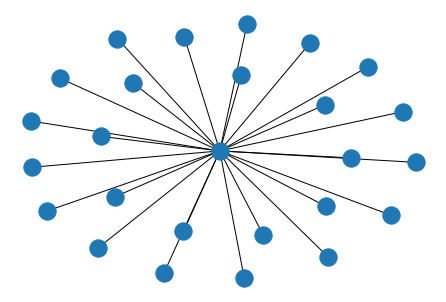

In [78]:
import networkx as nx
%matplotlib inline
import neo4jupyter
#neo4jupyter.init_notebook_mode()

command = """MATCH p=()-[r:FAZ_PARTE_DE]->() RETURN p LIMIT 25"""

result = graph.run(command)

print(result)

print(dir(result))

#print(dir(nx))
graphElement = result.to_subgraph()
print(dir(graphElement))
nodeElements = []
for d1 in graphElement.nodes:
    print(d1.nodes)
    nodeElements.append(d1.nodes[0]['id'])
    
edgeElements = []
for d2 in graphElement.relationships:
    #print(d2.forward)
    #print(d2.next())
    #print(d2.relationships)
    #print(d2.__class__.__name__)
    print('%s - %s' % (d2.nodes[0]['id'],d2.nodes[1]['id']) )
    edgeElements.append((d2.nodes[0]['id'],d2.nodes[1]['id']))
    
#g= result.get_graph()
g = nx.Graph()
g.add_nodes_from(nodeElements)
g.add_edges_from(edgeElements)
nx.draw(g)

In [38]:
print(dir(graph))

['__bool__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__name__', '__ne__', '__new__', '__nonzero__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_procedures', 'auto', 'begin', 'call', 'create', 'delete', 'delete_all', 'evaluate', 'exists', 'match', 'match_one', 'merge', 'name', 'node_cache', 'nodes', 'play', 'pull', 'push', 'relationship_cache', 'relationships', 'run', 'schema', 'separate', 'service']
